# Depth estimator for kitti

> Depth estimator


- skip_showdoc: true
- skip_exec: true

In [ ]:
import torch
import torchvision
from torchvision.datasets import VisionDataset, CocoDetection
from torchvision import transforms, datasets, utils
import urllib.request
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

In [ ]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /home/ben/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas = midas.eval()


In [ ]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")


Using cache found in /home/ben/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

transform

Compose(
    <function transforms.<locals>.<lambda>>
    <midas.transforms.Resize object>
    <midas.transforms.NormalizeImage object>
    <midas.transforms.PrepareForNet object>
    <function transforms.<locals>.<lambda>>
)

## Getting Images

In [ ]:
from PIL import Image
from torchvision.transforms import ToPILImage

In [ ]:
train_path = 'Data/Kitti_v2/raw/training/image_2'
train_images = os.listdir(train_path)
train_files = [f'{train_path}/{image}' for image in train_images]

In [ ]:
folder = train_files[2].rsplit('/', 5)
folder

['Data/Kitti_v2', 'raw', 'training', 'image_2', '001412.png']

In [ ]:
img = cv2.imread(train_files[2])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

<matplotlib.image.AxesImage>

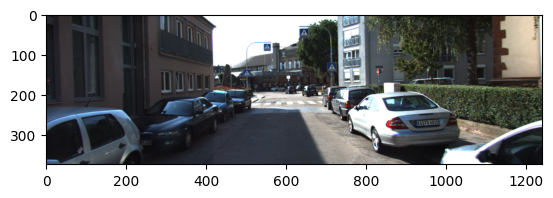

In [ ]:
plt.imshow(img)

In [ ]:
input_batch = transform(img).to(device)
input_batch.shape

torch.Size([1, 3, 384, 1280])

In [ ]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
    
img_range = (torch.max(prediction) - torch.min(prediction))
prediction1 = ((prediction - torch.min(prediction)) / img_range) * 255
prediction1 = prediction1.round().to(torch.uint8)
output = prediction1.cpu().numpy()

(-0.5, 1241.5, 374.5, -0.5)

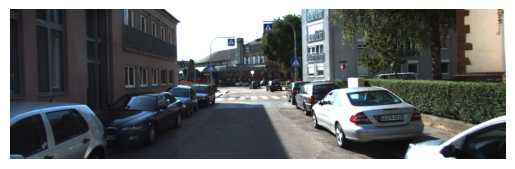

In [ ]:
plt.imshow(img)
plt.axis("off")

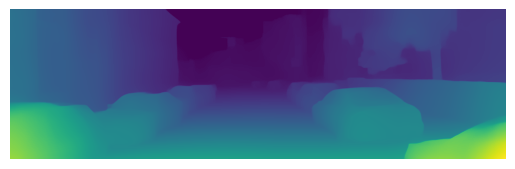

In [ ]:
plt.imshow(output)
plt.axis("off")
plt.show()

## Resave Coountry211 as RGB_D

In [ ]:
import os

def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder '{folder_path}' created.")

def resave_images(filename):
    folder = filename.rsplit('/', 10)
    
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    input_batch = transform(img).to(device)
    input_batch.shape
    
    with torch.no_grad():
        prediction = midas(input_batch)
    
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()
    
    img_range = (torch.max(prediction) - torch.min(prediction))
    prediction1 = ((prediction - torch.min(prediction)) / img_range) * 255
    prediction1 = prediction1.round().to(torch.uint8)
    output = prediction1.cpu()

    image_array = np.expand_dims(output.numpy(), axis=-1)
    # Combine the RGB array and the grayscale array along the channel axis
    combined_array = np.concatenate((img, image_array), axis=-1)
    combined_image = Image.fromarray(combined_array)

    folder_path = f'{folder[0]}/Kitti_depth/Kitti_v2/{folder[2]}/{folder[3]}/{folder[4]}'
    create_folder_if_not_exists(folder_path)

    name = folder[-1].rsplit('.', 1)

    combined_image.save(f'{folder_path}/{name[0]}.png')
    return combined_array, folder_path

In [ ]:
combined_image, folder_path = resave_images(train_files[0])

Folder 'Data/Kitti_depth/Kitti_v2/raw/training/image_2' created.


In [ ]:
folder_path

'Data/Kitti_depth/Kitti_v2/raw/training/image_2'

In [ ]:
combined_image.shape

(375, 1242, 4)

In [ ]:
folder_path

'Data/Kitti_depth/Kitti_v2/raw/training/image_2'

In [ ]:
len(train_files)

7481

In [ ]:
for train_data in tqdm(train_files):
    combined_image, folder_path = resave_images(train_data)

100%|█████████████████████████████████████████████████████████████████████████████| 7481/7481 [2:10:04<00:00,  1.04s/it]


In [ ]:
# for val_data in tqdm(val_files):
#     combined_image, folder_path = resave_images(val_data)

  0%|▍                                                                                  | 1/200 [00:00<02:08,  1.55it/s]

Folder 'Data/coco_depth/validation/data' created.


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [01:28<00:00,  2.27it/s]
